In [1]:
from dataset.MatDataset import BurgersDataset
import torch
from models.teecnet import TEECNetConv
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import os

In [2]:
def plot_prediction(window_size, y, y_pred, epoch, batch_idx, folder):
    xx, yy = np.meshgrid(np.linspace(0, 1, window_size), np.linspace(0, 1, window_size))
    fig, axs = plt.subplots(1, 3, figsize=(17, 5))
    axs[0].contourf(xx, yy, y.cpu().detach().numpy().reshape(window_size, window_size), levels=100, cmap='plasma')
    axs[0].set_title('(a) Ground truth')
    axs[0].axis('off')
    axs[1].contourf(xx, yy, y_pred.reshape(window_size, window_size), levels=100, cmap='plasma')
    axs[1].set_title('(b) Prediction')
    axs[1].axis('off')
    axs[2].contourf(xx, yy, np.abs(y.cpu().detach().numpy().reshape(window_size, window_size) - y_pred.reshape(window_size, window_size)), levels=100, cmap='plasma')
    axs[2].set_title('(c) Absolute difference')
    axs[2].axis('off')

    # plt.colorbar(axs[2].contourf(xx, yy, np.abs(y.cpu().detach().numpy().reshape(window_size, window_size) - y_pred.reshape(window_size, window_size)), levels=100, cmap='plasma'), ax=axs[2], pad=0.01)

    plt.savefig(os.path.join(folder, f'epoch_{epoch}_batch_{batch_idx}.png'))
    # wandb.log({'prediction': wandb.Image(plt)})
    plt.close()

  0%|          | 0/990 [00:00<?, ?it/s]C:\Users\xuwen\AppData\Local\Temp\ipykernel_28360\3033759109.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data[1] = torch.tensor(data[1], dtype=torch.float)
100%|██████████| 990/990 [13:00<00:00,  1.27it/s]


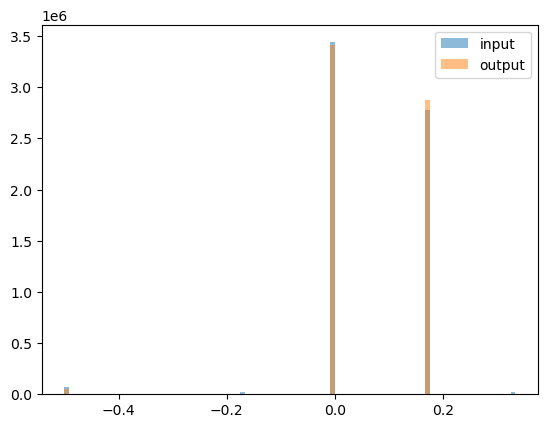

In [4]:
model = TEECNetConv(1, 32, 1, num_layers=6, retrieve_weights=False, num_powers=3, sub_size=6)
dataset = BurgersDataset(root='data/burgers')

fft_x_list = []
fft_y_list = []

sub_x_total = []
sub_y_total = []

for data in tqdm.tqdm(dataset):
    data[0] = torch.tensor(data[0], dtype=torch.float)
    data[1] = torch.tensor(data[1], dtype=torch.float)
    sub_x_list, sub_y_list = model.get_partition_domain(data[0], mode='train'), model.get_partition_domain(data[1], mode='test')
    sub_x_total.append(sub_x_list)
    sub_y_total.append(sub_y_list)
    for sub_x, sub_y in zip(sub_x_list, sub_y_list):
        # calculate fft of sub_x and sub_y
        sub_x_fft = torch.fft.fftn(sub_x[:, :, :, 0].squeeze(0))
        sub_y_fft = torch.fft.fftn(sub_y[:, :, :, 0].squeeze(0))

        # calculate the dominant frequencies
        sub_x_fft_abs = torch.abs(sub_x_fft)
        sub_y_fft_abs = torch.abs(sub_y_fft)

        power_spectrum_x = sub_x_fft_abs**2
        power_spectrum_y = sub_y_fft_abs**2

        power_spectrum_x[0, 0] = 0
        power_spectrum_y[0, 0] = 0

        sub_x_freq = torch.fft.fftfreq(sub_x_fft_abs.size(0))
        sub_y_freq = torch.fft.fftfreq(sub_y_fft_abs.size(0))

        sub_x_freq_max = sub_x_freq[torch.argmax(power_spectrum_x) % sub_x_freq.size(0)]
        sub_y_freq_max = sub_y_freq[torch.argmax(power_spectrum_y) % sub_y_freq.size(0)]

        # store the dominant frequencies
        fft_x_list.append(sub_x_freq_max)
        fft_y_list.append(sub_y_freq_max)


# plot the distribution of the dominant frequencies of the input and output
plt.hist(fft_x_list, bins=100, alpha=0.5, label='input')
plt.hist(fft_y_list, bins=100, alpha=0.5, label='output')
plt.legend(loc='upper right')
plt.savefig('dominant_frequencies.png')

# save the sub_x_total and sub_y_total lists and the fft_x_list and fft_y_list lists
torch.save(sub_x_total, 'sub_x_total.pt')
torch.save(sub_y_total, 'sub_y_total.pt')
torch.save(fft_x_list, 'fft_x_list.pt')
torch.save(fft_y_list, 'fft_y_list.pt')

In [3]:
# load the sub_x_total and sub_y_total lists and the fft_x_list and fft_y_list lists
sub_x_total = torch.load('sub_x_total.pt')
# sub_y_total = torch.load('sub_y_total.pt')
fft_x_list = torch.load('fft_x_list.pt')
# fft_y_list = torch.load('fft_y_list.pt')

# # plot the samples where -0.6<fft_x<-0.4
# for i, (sub_x, sub_y, fft_x, fft_y) in enumerate(zip(sub_x_total, sub_y_total, fft_x_list, fft_y_list)):
#     if -0.6 < fft_x < -0.4:
#         plot_prediction(64, sub_x, sub_y, 0, i, 'results')

In [ ]:
sub_x_total.shape

AttributeError: 'list' object has no attribute 'shape'